# Notebook 4: Inference and App Preparation

### Objectives:
1.  **Load the Best Model:** Load the saved weights of our winning model (`ResNetUNet`).
2.  **Create an Inference Pipeline:** Develop a robust function that takes a single image file, preprocesses it, and runs it through the model to get a segmentation mask.
3.  **Test the Pipeline:** Verify that our inference function works correctly on a sample image, creating the final logic we'll use in our Streamlit application.

## 1. Setup, Imports, and Path Definitions

First, we import the necessary libraries and define our project paths. We also import our model architectures from the `src` directory.

In [24]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt

# --- Define Project Directories ---
try:
    ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
except NameError:
    ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

# --- Add Project Root to Python Path ---
# This is the crucial step that allows us to import from the 'src' directory
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

print(f"Project Root added to path: {ROOT_DIR}")

# --- Import our custom models (this will now work)---
from src.models import BaselineUNet, ResNetUNet, TransUNet

MODELS_DIR = os.path.join(ROOT_DIR, 'models')
FIGURES_DIR = os.path.join(ROOT_DIR, 'figures')

# --- Set Device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Root Directory: {ROOT_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"Device: {DEVICE}")

Project Root added to path: D:\Coding\GitHub\MRI-Tumor-Segmentation
Root Directory: D:\Coding\GitHub\MRI-Tumor-Segmentation
Models Directory: D:\Coding\GitHub\MRI-Tumor-Segmentation\models
Device: cuda


## 2. Load the Best Trained Model

Based on our benchmark results, the `ResNetUNet` was the clear winner. We will now load its saved weights into a model instance and set it to evaluation mode.

In [25]:
BEST_MODEL_NAME = 'ResNetUNet'
model_path = os.path.join(MODELS_DIR, f'{BEST_MODEL_NAME}_best_model.pth')

# Instantiate the model architecture
model = ResNetUNet(in_channels=4, out_channels=1).to(DEVICE)

# Load the saved weights
model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))

# Set the model to evaluation mode
model.eval()

print(f"Successfully loaded best model: {BEST_MODEL_NAME} from {model_path}")

Successfully loaded best model: ResNetUNet from D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth


## 3. Create the Inference Pipeline

Here we create a single, powerful function called `predict`. This function encapsulates all the necessary steps: opening an image, preprocessing it to match the training format, running inference, and post-processing the output mask. This is the core function we will use in our Streamlit app.

In [26]:
# =========================================================================
#             CREATE THE INFERENCE PIPELINE (CORRECTED)
# =========================================================================

def predict(model, npy_image_path, device):
    """
    Runs the full inference pipeline on a single, preprocessed .npy image slice.
    """
    # Load the correctly preprocessed numpy array
    img_np = np.load(npy_image_path)
    
    # Convert to PyTorch tensor and add batch dimension
    input_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        # Get raw prediction (logits)
        logits = model(input_tensor)
        # Convert to probabilities -> binary mask
        pred_mask = (torch.sigmoid(logits) > 0.5).float()
        
    # Remove batch dimension and move to CPU
    pred_mask = pred_mask.squeeze(0).cpu().numpy()
    
    return pred_mask

## 4. Creating Sample Images for App Deployment & Testing the Pipeline
This cell takes a few images from our test set and saves them as user-friendly .png files for the application demo.

--- Creating Sample Images & Verifying Inference Pipeline ---
Samples will be saved to and tested from: D:\Coding\GitHub\MRI-Tumor-Segmentation\streamlit_app\sample_images

--- Verification for sample_1.png ---


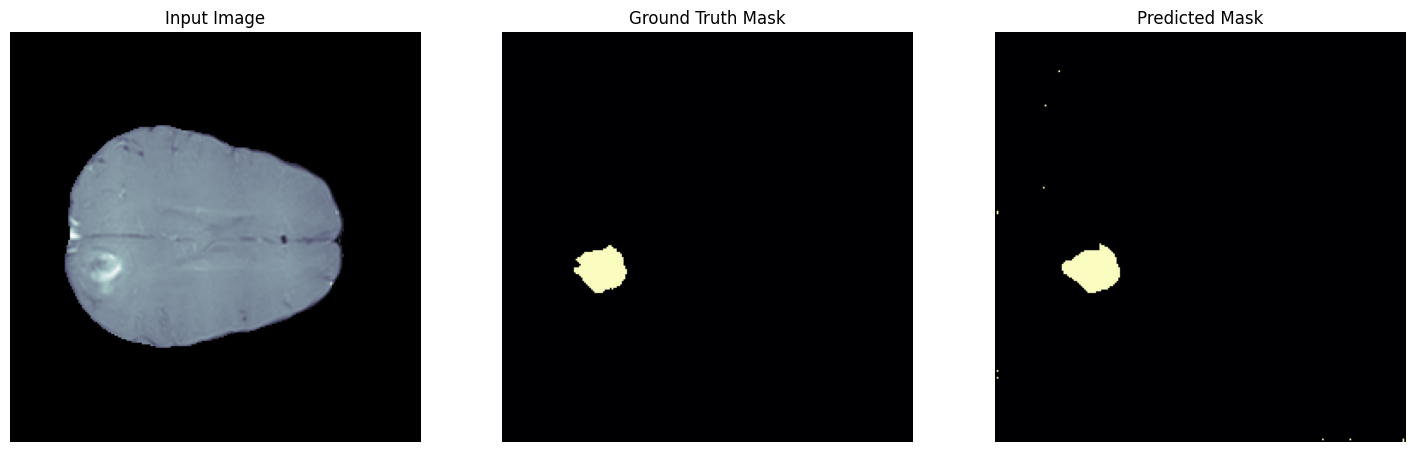


--- Verification for sample_2.png ---


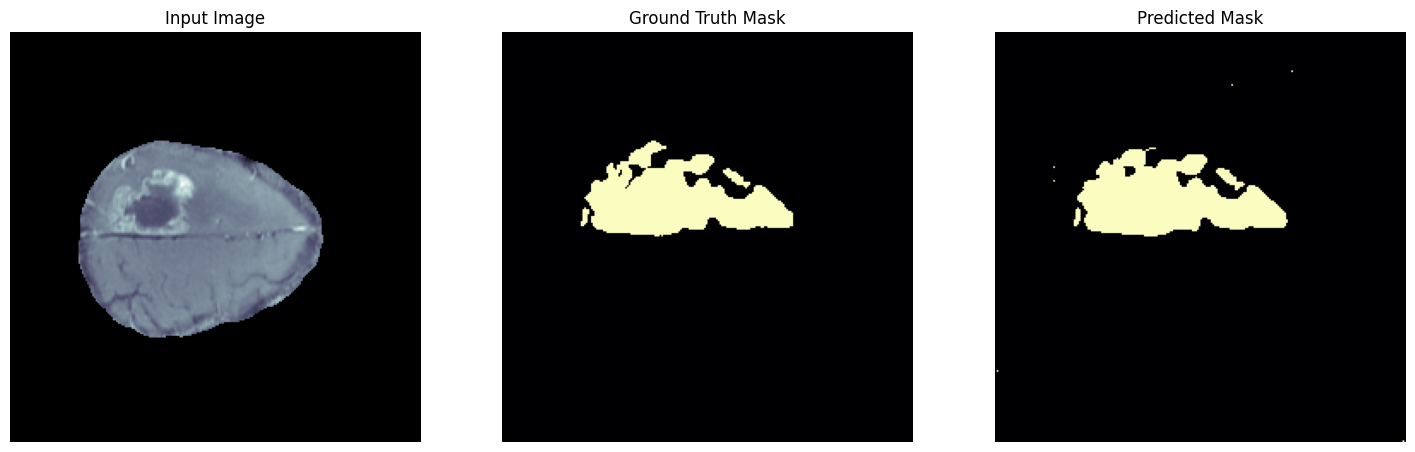


--- Verification for sample_3.png ---


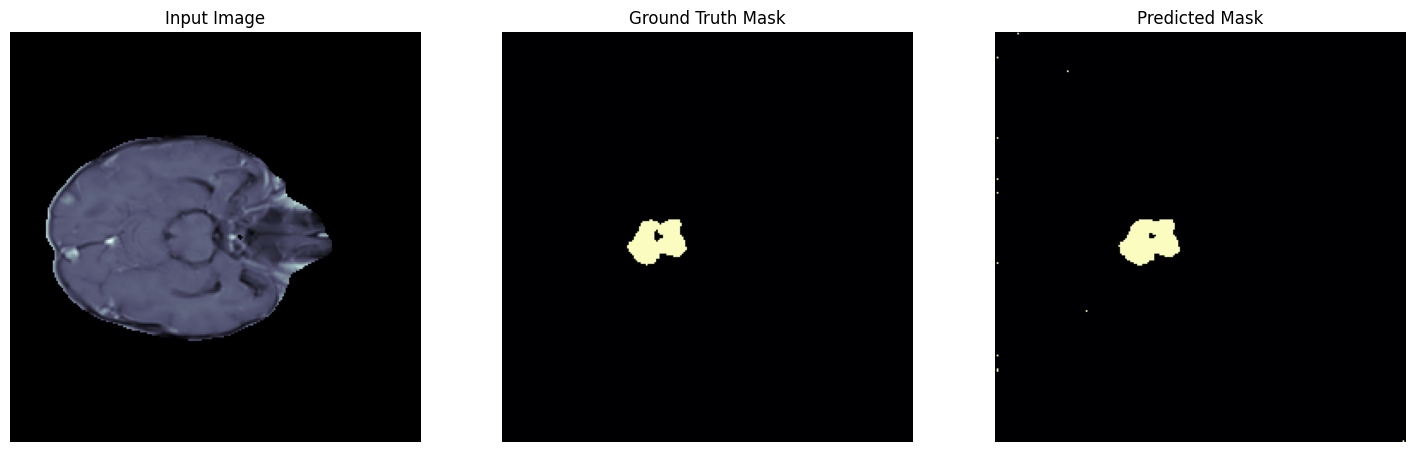


--- Verification for sample_4.png ---


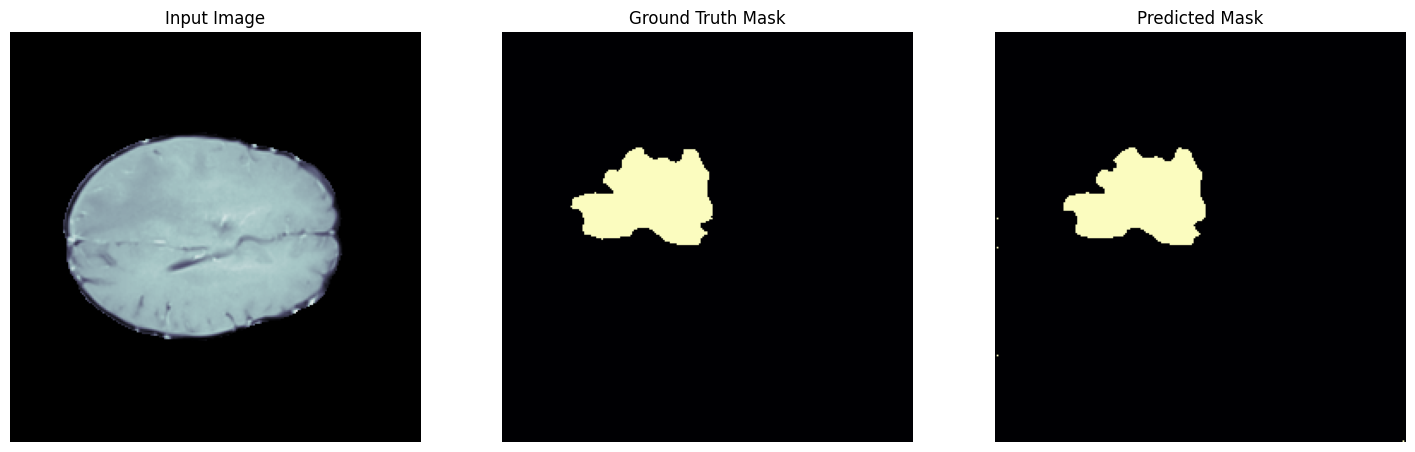


--- Verification for sample_5.png ---


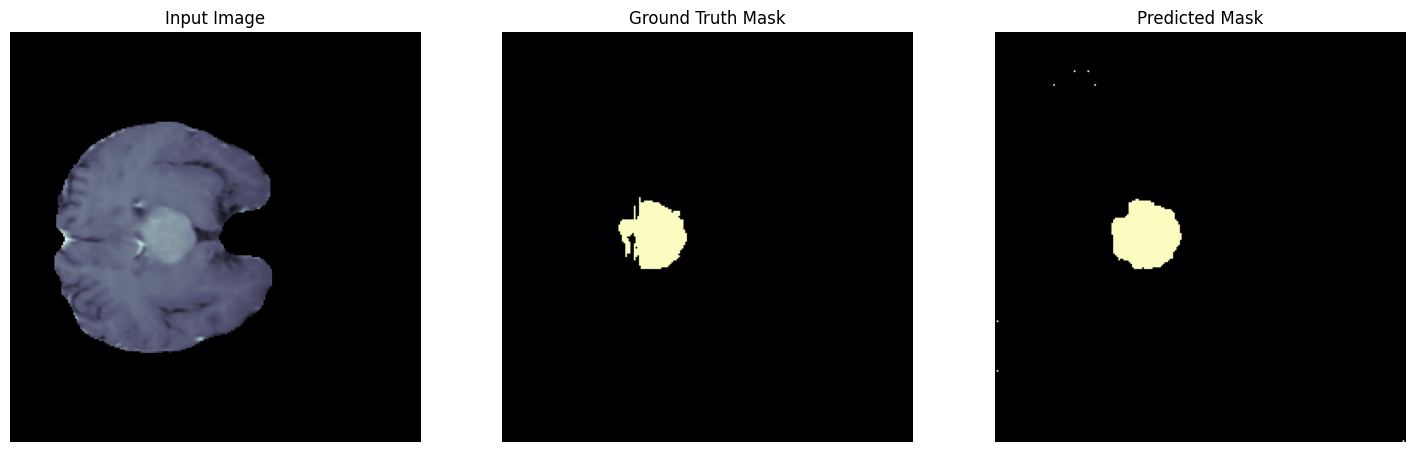



--- 5 sample images and masks created and verified successfully. ---


In [27]:
# =========================================================================
#       FINAL CELL: CREATE SAMPLES & TEST INFERENCE PIPELINE (CORRECTED)
# This version uses the .npy file for prediction to ensure no preprocessing skew.
# =========================================================================

from sklearn.model_selection import train_test_split
from glob import glob
import random

print("--- Creating Sample Images & Verifying Inference Pipeline ---")

# --- 1. Re-create the test set file list ---
PROCESSED_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'processed')
all_files = glob(os.path.join(PROCESSED_DATA_DIR, "*_image.npy"))
_, test_files = train_test_split(all_files, test_size=0.15, random_state=42)

# --- 2. Define the sample directory ---
SAMPLE_IMAGES_DIR = os.path.join(ROOT_DIR, 'streamlit_app', 'sample_images')
os.makedirs(SAMPLE_IMAGES_DIR, exist_ok=True)
print(f"Samples will be saved to and tested from: {SAMPLE_IMAGES_DIR}")

# --- 3. Select random test files ---
num_samples_to_create = 5
random_test_npy_paths = random.sample(test_files, num_samples_to_create)

# --- 4. Loop, Create, Predict, and Visualize ---
for i, npy_path in enumerate(random_test_npy_paths):
    
    # --- a. Run INFERENCE on the .npy file FIRST ---
    # This is the crucial step: predict using the correctly processed data
    predicted_mask_array = predict(model, npy_path, DEVICE)
    
    # --- b. Create the .png files for visualization and app use ---
    mri_slice = np.load(npy_path)[:, :, 0] # T1c channel
    mask_slice = (np.load(npy_path.replace("_image.npy", "_mask.npy")) > 0).astype(np.uint8)

    img_to_save = Image.fromarray((mri_slice * 255).astype(np.uint8))
    mask_to_save = Image.fromarray(mask_slice * 255)

    img_save_path = os.path.join(SAMPLE_IMAGES_DIR, f"sample_{i+1}.png")
    mask_save_path = os.path.join(SAMPLE_IMAGES_DIR, f"sample_{i+1}_mask.png")
    img_to_save.save(img_save_path)
    mask_to_save.save(mask_save_path)
    
    # --- c. Visualize the result ---
    print(f"\n--- Verification for sample_{i+1}.png ---")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    ax1.imshow(img_to_save, cmap='bone'); ax1.set_title('Input Image'); ax1.axis('off')
    ax2.imshow(mask_to_save, cmap='magma'); ax2.set_title('Ground Truth Mask'); ax2.axis('off')
    ax3.imshow(predicted_mask_array.squeeze(), cmap='magma'); ax3.set_title(f'Predicted Mask'); ax3.axis('off')
    
    plt.show()

print(f"\n\n--- {num_samples_to_create} sample images and masks created and verified successfully. ---")

## End of Notebook 4

This concludes our inference preparation. We have successfully:
- Loaded our best-performing `ResNetUNet` model.
- Built and tested a robust `predict` function that handles the full preprocessing and inference pipeline.

We are now fully prepared to build the interactive Streamlit application.